In [2]:
import numpy as np
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import Steerable.nn as snn

sys.path.append('data/ModelNet10/')
from ModelNet10 import ModelNet10

# Two Dimension

## Model

In [3]:
device = torch.device('cuda')
class Model(torch.nn.Module):
    def __init__(self, n_layers) -> None:
        super().__init__()
        n_radius = 2
        max_m = 8
        n_theta = 40
        
        self.network = torch.nn.Sequential(
            snn.SE2ConvType1(1, 10, 4,n_radius=n_radius, n_theta=n_theta, max_m=max_m, stride=4),
            snn.SE2TransformerEncoder(10, 2, 8, n_layers=n_layers, dropout=0,add_pos_enc=True),
        )
        
        self.flatten = snn.SE2NormFlatten()
    
    def forward(self,x):
        x = self.network(x.type(torch.cfloat))
        return self.flatten(x)

## Dataset

In [4]:
resize1 = transforms.Resize(56)
resize2 = transforms.Resize(28)
normalize = transforms.Normalize(0,1)

def rotate_image(image, degree):
    return normalize(resize2(snn.rotate_2D_image(resize1(image), degree)))


transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])
dataset = torchvision.datasets.MNIST('data/', train=True, transform=transformations)

## Equivariance Error

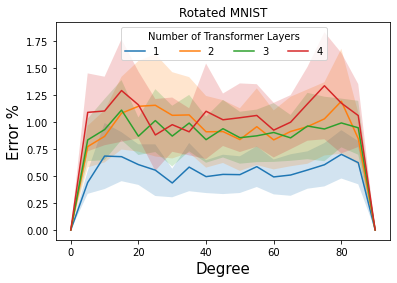

In [5]:
n_sim = 50
layers = torch.arange(1,5)
degrees = torch.arange(0, 95, 5)
values = torch.zeros(n_sim, len(layers),len(degrees))

torch.manual_seed(1)
for sim in range(n_sim):
    index = torch.randint(0, len(dataset), (1,)).item()
    inputs = dataset[index][0].unsqueeze(0)
    
    for i, layer in enumerate(layers):
        model = Model(n_layers=layer).to(device)
        with torch.no_grad():    
            outputs1 = model(rotate_image(inputs, 0).to(device))
            for j, degree in enumerate(degrees):
                outputs2 = model(rotate_image(inputs, degree).to(device))
                
                diff = torch.linalg.vector_norm(outputs1 - outputs2)
                norm1, norm2 = torch.linalg.vector_norm(outputs1), torch.linalg.vector_norm(outputs2)
                values[sim, i, j] = (diff**2/(norm1*norm2)).item()
        
    print(f'{sim+1} / {n_sim}', end='\r')

mean = values.mean(dim=0)*100
error = 1.96*values.std(dim=0)*100/np.sqrt(n_sim)

for i, layer in enumerate(layers):
    plt.plot(degrees, mean[i], label=layer.item())
    plt.fill_between(degrees, mean[i] - error[i], mean[i] + error[i], alpha=0.2)
plt.xlabel('Degree', fontsize = 15)
plt.ylabel('Error %', fontsize = 15)
plt.legend(title='Number of Transformer Layers', ncol=len(layers), bbox_to_anchor=[0.825,1])
plt.title('Rotated MNIST')
plt.show()

# Three Dimension

## Model

In [6]:
device = torch.device('cuda')
class Model(torch.nn.Module):
    def __init__(self, n_layers) -> None:
        super().__init__()
        n_radius = 2
        n_theta = 40
        
        self.network = torch.nn.Sequential(
            snn.SE3Conv(1, [4,4,2], 4, n_radius=n_radius, n_theta=n_theta, stride=4),
            snn.SE3TransformerEncoder([4,4,2], 2, n_layers=n_layers, add_pos_enc=True),
            snn.SE3NormFlatten()
        )
    
    def forward(self,x):
        return self.network(x.type(torch.cfloat))

## Dataset

In [7]:
resize1 = torch.nn.Upsample(size=(64, 64, 64))
resize2 = torch.nn.Upsample(size=(32, 32, 32))
normalize = transforms.Normalize(0,1)

def rotate_image(image, degree):
    return normalize(resize2(snn.rotate_3D_image(resize1(image), degree)))

transformations = transforms.Compose([
    transforms.Normalize(0,1)
])
dataset = ModelNet10('data/ModelNet10/', size=32, train=True, transform=transformations, download=True)

## Equivariance Error

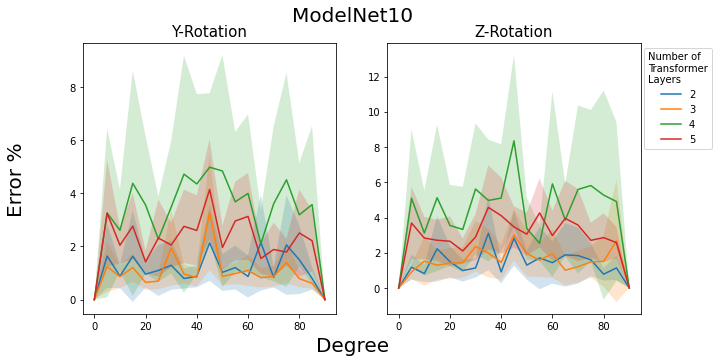

In [8]:
n_sim = 50
layers = torch.arange(2,6)
degrees = torch.arange(0, 95, 5)
values = torch.zeros(n_sim, len(layers), 2, len(degrees))

torch.manual_seed(1)
for sim in range(n_sim):
    index = torch.randint(0, len(dataset), (1,)).item()
    inputs = dataset[index][0].unsqueeze(0)

    for i, layer in enumerate(layers):
        model = Model(n_layers=layer).to(device)
        with torch.no_grad():    
            outputs1 = model(rotate_image(inputs, (0,0,0)).to(device))
            norm1 = torch.linalg.vector_norm(outputs1)
            for j, degree in enumerate(degrees):
                outputs2 = model(rotate_image(inputs, (0,degree,0)).to(device))
                diff  = torch.linalg.vector_norm(outputs1 - outputs2)
                norm2 = torch.linalg.vector_norm(outputs2)
                values[sim, i, 0, j] = (diff**2/(norm1*norm2)).item()
                
                outputs3 = model(rotate_image(inputs, (degree,0,0)).to(device))
                diff = torch.linalg.vector_norm(outputs1 - outputs3)
                norm3 = torch.linalg.vector_norm(outputs3)
                values[sim, i, 1, j] = (diff**2/(norm1*norm3)).item()
        
    print(f'{sim+1} / {n_sim}', end='\r')

mean = values.mean(dim=0)*100
error = 1.96*values.std(dim=0)*100/np.sqrt(n_sim)


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
for i, layer in enumerate(layers):
    for j, ax in enumerate(axes):
        ax.plot(degrees, mean[i,j], label=layer.item())
        ax.fill_between(degrees, mean[i,j] - error[i,j], mean[i,j] + error[i,j], alpha=0.2)
    ax.legend(title='Number of\nTransformer\nLayers', bbox_to_anchor=[1.3,1])

plt.suptitle('ModelNet10', fontsize = 20)
fig.supxlabel('Degree', fontsize = 20)
fig.supylabel('Error %', fontsize = 20)
axes[0].set_title('Y-Rotation', fontsize = 15)
axes[1].set_title('Z-Rotation', fontsize = 15)
plt.show()